In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd

# Assuming your file is in Excel format, use read_excel
data = pd.read_csv('/content/drive/MyDrive/climate/Maximum1.csv')
data.head()



,Station,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,Year
0,36,23.4,28.7,32.0,33.4,33.4,32.6,32.3,31.1,32.4,32.8,29.7,25.0,30.57
1,126,22.7,28.2,31.7,33.6,33.4,33.2,32.7,32.6,32.8,33.3,29.5,24.0,30.23
2,85,22.2,27.3,29.9,31.9,31.7,32.0,31.6,31.3,32.2,32.5,28.7,24.5,29.65
3,44,23.0,28.5,32.5,33.7,33.6,32.9,32.4,31.2,32.4,33.6,29.9,24.3,30.67
4,79,23.8,28.9,32.6,33.5,33.8,32.7,32.1,31.4,32.0,33.1,30.0,25.9,30.82


In [12]:
X = data.drop(['Year'], axis=1)
y = data['Year']

# Display the modified feature dataset
print(X)

# Display the target dataset
print(y)



     Station   Jan   Feb   Mar   Apr   May  June  July   Aug   Sep   Oct  \
0         36  23.4  28.7  32.0  33.4  33.4  32.6  32.3  31.1  32.4  32.8   
1        126  22.7  28.2  31.7  33.6  33.4  33.2  32.7  32.6  32.8  33.3   
2         85  22.2  27.3  29.9  31.9  31.7  32.0  31.6  31.3  32.2  32.5   
3         44  23.0  28.5  32.5  33.7  33.6  32.9  32.4  31.2  32.4  33.6   
4         79  23.8  28.9  32.6  33.5  33.8  32.7  32.1  31.4  32.0  33.1   
..       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
426       39  23.6  26.9  30.0  33.1  33.9  32.9  33.1  32.7  33.0  31.1   
427       70  24.8  30.3  33.2  37.0  35.1  35.2  34.5  33.1  33.7  32.7   
428      134  23.7  27.1  30.1  32.7  33.2  32.8  32.8  32.4  33.3  31.5   
429       91  23.9  23.6  27.7  30.1  34.8  34.1  33.3  34.1  32.5  34.1   
430       88  25.1  24.8  29.2  32.2  35.8  34.4  33.8  34.0  32.4  33.8   

      Nov   Dec  
0    29.7  25.0  
1    29.5  24.0  
2    28.7  24.5  
3    29.9  24.3

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define Huber loss function
def huber_loss(delta=1.0):
    def loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= delta
        return tf.where(is_small_error,
                        0.5 * tf.square(error),
                        delta * (tf.abs(error) - 0.5 * delta))
    return loss

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (convert to numpy array before reshaping)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Flatten to 1D
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Build an improved ANN model with more hidden layers and regularization
model = Sequential()

# Input Layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='linear'))

# Compile the model with the Huber loss function
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=huber_loss(delta=1.0), metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=16, validation_split=0.2, verbose=1)

# Predictions and inverse scaling
ann_pred_scaled = model.predict(X_test_scaled)
ann_pred = scaler_y.inverse_transform(ann_pred_scaled)  # This returns a 2D array

# Flatten the predictions to ensure they are 1D
ann_pred = ann_pred.flatten()

# Performance evaluation for the ANN model
mae = mean_absolute_error(y_test, ann_pred)
mse = mean_squared_error(y_test, ann_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, ann_pred)
rmsle = np.sqrt(np.mean((np.log1p(ann_pred) - np.log1p(y_test)) ** 2))  # Corrected RMSLE calculation
mape = np.mean(np.abs((y_test - ann_pred) / y_test)) * 100

print(f"\nImproved ANN Model with Huber Loss:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Combine predictions with Huber Regressor
# Assuming `huber_pred` is already calculated from your earlier code
# You may want to recalculate huber_pred here if needed
# For example:
huber_reg = HuberRegressor(epsilon=1.35)
huber_reg.fit(X_train, y_train)
huber_pred = huber_reg.predict(X_test)

# Weight optimization for predictions
weight = 0.5  # Set your optimal weight value based on previous evaluations
ensemble_pred = (weight * huber_pred) + ((1 - weight) * ann_pred)

# Performance evaluation for the ensemble model
mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
mse_ensemble = mean_squared_error(y_test, ensemble_pred)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_test, ensemble_pred)
rmsle_ensemble = np.sqrt(np.mean((np.log1p(ensemble_pred) - np.log1p(y_test)) ** 2))  # Corrected RMSLE calculation
mape_ensemble = np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100

print(f"\nEnsemble Model (Huber Regressor + ANN) with Weight {weight:.2f}:")
print(f"Mean Absolute Error (MAE): {mae_ensemble:.2f}")
print(f"Mean Squared Error (MSE): {mse_ensemble:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble:.2f}")
print(f"R-squared (R2): {r2_ensemble:.2f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_ensemble:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ensemble:.2f}%")


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0792 - mae: 0.2675 - val_loss: 0.1351 - val_mae: 0.2327
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1796 - mae: 0.3278 - val_loss: 0.1288 - val_mae: 0.2241
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0738 - mae: 0.2118 - val_loss: 0.1250 - val_mae: 0.2217
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0554 - mae: 0.1888 - val_loss: 0.1226 - val_mae: 0.2131
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1311 - mae: 0.2712 - val_loss: 0.1201 - val_mae: 0.2004
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0850 - mae: 0.1965 - val_loss: 0.1158 - val_mae: 0.1926
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1409 - mae: 0.2629 - val_loss: 0.1109 - val_mae: 0.1831
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1091 - mae: 0.2224 - val_loss: 0.1109 - val_mae: 0.1757
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0676 - mae: 0.

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Improved ANN Model with Huber Loss:
Mean Absolute Error (MAE): 0.12
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.19
R-squared (R2): 1.00
Root Mean Squared Logarithmic Error (RMSLE): 0.01
Mean Absolute Percentage Error (MAPE): 0.37%

Ensemble Model (Huber Regressor + ANN) with Weight 0.50:
Mean Absolute Error (MAE): 0.07
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.14
R-squared (R2): 1.00
Root Mean Squared Logarithmic Error (RMSLE): 0.00
Mean Absolute Percentage Error (MAPE): 0.22%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor

# Load the new dataset for 2023
test_data = pd.read_csv('/content/drive/MyDrive/climate/up_maximum_23.csv')
print(test_data.head())  # Check the structure of the test data

# Prepare the features (use all columns except 'Year')
X_test_2023 = test_data.drop(['Year'], axis=1)  # Drop 'Year' for features
y_test_2023 = test_data['Year']  # Keep 'Year' as the target

# Scale the features using the same scaler as before
scaler_X = StandardScaler()
X_test_2023_scaled = scaler_X.fit_transform(X_test_2023)

# Make predictions using the trained ANN model
ann_pred_2023_scaled = model.predict(X_test_2023_scaled)
ann_pred_2023 = scaler_y.inverse_transform(ann_pred_2023_scaled).flatten()  # Inverse scaling and flattening

# Make predictions using the Huber Regressor
huber_reg = HuberRegressor(epsilon=1.35)
huber_reg.fit(X_train, y_train)  # Ensure Huber is trained with the same training set
huber_pred_2023 = huber_reg.predict(X_test_2023)  # Predicting using the Huber Regressor

# Weight optimization for predictions
weight = 0.5  # Adjust this weight based on your evaluation
ensemble_pred = (weight * huber_pred_2023) + ((1 - weight) * ann_pred_2023)

# Add the ensemble predictions to the test data
test_data['Predicted Value'] = ensemble_pred

# Save the results to a new CSV file
output_file_path = '/content/drive/MyDrive/climate/predicted_maximum_2023.csv'
test_data.to_csv(output_file_path, index=False)

print(f"Ensemble predictions saved to {output_file_path}")


   Station   Jan   Feb   Mar   Apr   May  June  July   Aug   Sep   Oct   Nov  \
0       10  25.1  29.3  32.4  36.4  35.4  34.2  34.4  32.7  34.0  32.8  30.9   
1       42  24.3  28.9  31.8  35.8  35.1  34.8  34.7  33.1  34.4  32.8  31.1   
2       28  24.4  27.9  29.8  34.1  33.5  32.8  33.6  32.7  33.5  31.6  30.7   
3       13  24.6  29.6  32.5  36.7  34.6  33.9  34.4  33.2  33.6  33.0  31.1   
4       25  24.1  28.5  31.7  35.5  34.8  34.0  33.9  32.4  32.9  32.1  29.9   

    Dec       Year  
0  26.7  32.025000  
1  26.4  31.933333  
2  26.4  30.916667  
3  26.7  31.991667  
4  25.8  31.300000  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ensemble predictions saved to /content/drive/MyDrive/climate/predicted_maximum_2023.csv


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


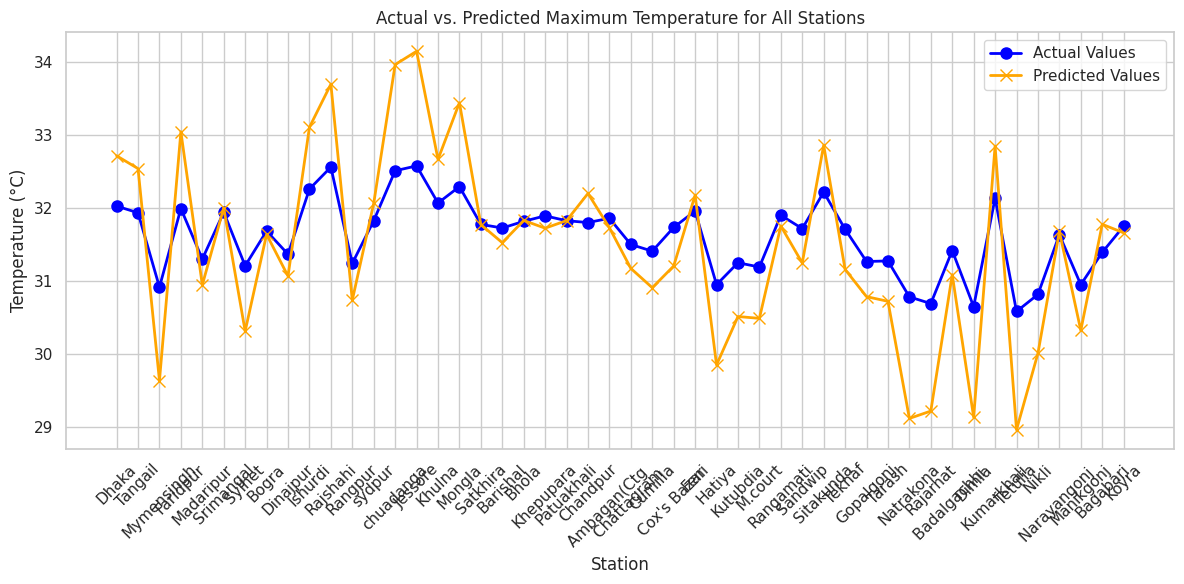

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predicted results CSV file
predicted_data = pd.read_csv('/content/drive/MyDrive/climate/pre_maximum_23.csv')

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual values for all stations
plt.plot(predicted_data['Station'], predicted_data['Actual Year'],
         label='Actual Values', marker='o', color='blue', linewidth=2, markersize=8)

# Plot predicted values for all stations
plt.plot(predicted_data['Station'], predicted_data['Predicted Value'],
         label='Predicted Values', marker='x', color='orange', linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Actual vs. Predicted Maximum Temperature for All Stations')
plt.xlabel('Station')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


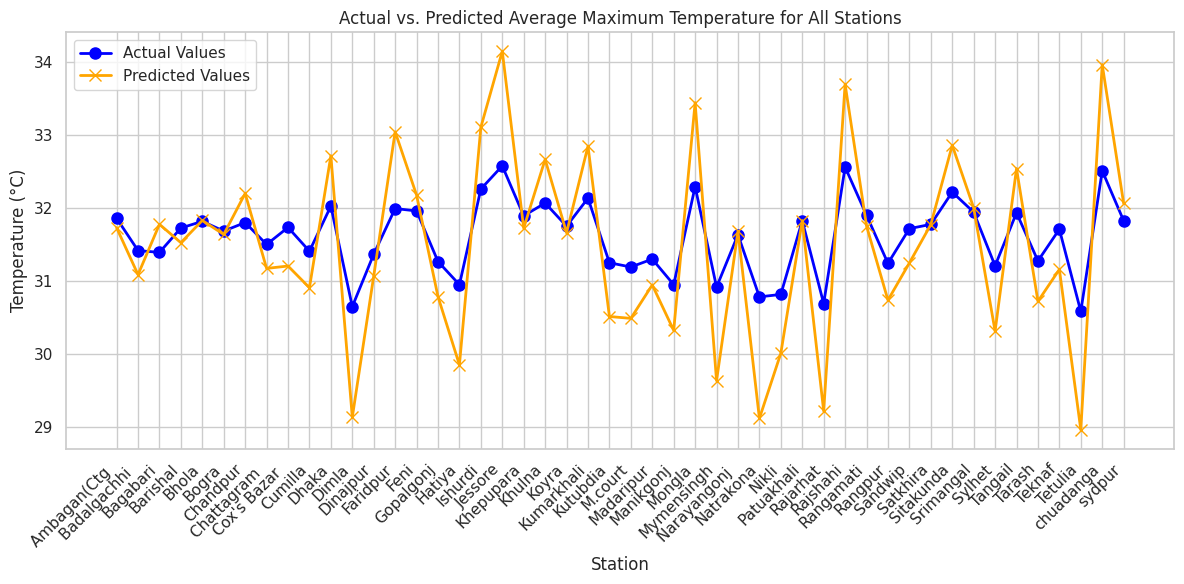

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predicted results CSV file
predicted_data = pd.read_csv('/content/drive/MyDrive/climate/pre_maximum_23.csv')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Sort the data by station if needed (optional, depending on station order)
predicted_data = predicted_data.sort_values('Station')

# Plot actual values for all stations
plt.plot(predicted_data['Station'], predicted_data['Actual Year'],
         label='Actual Values', marker='o', color='blue', linewidth=2, markersize=8)

# Plot predicted values for all stations
plt.plot(predicted_data['Station'], predicted_data['Predicted Value'],
         label='Predicted Values', marker='x', color='orange', linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Actual vs. Predicted Average Maximum Temperature for All Stations')
plt.xlabel('Station')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45, ha='right')  # Ensure stations are properly spaced
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


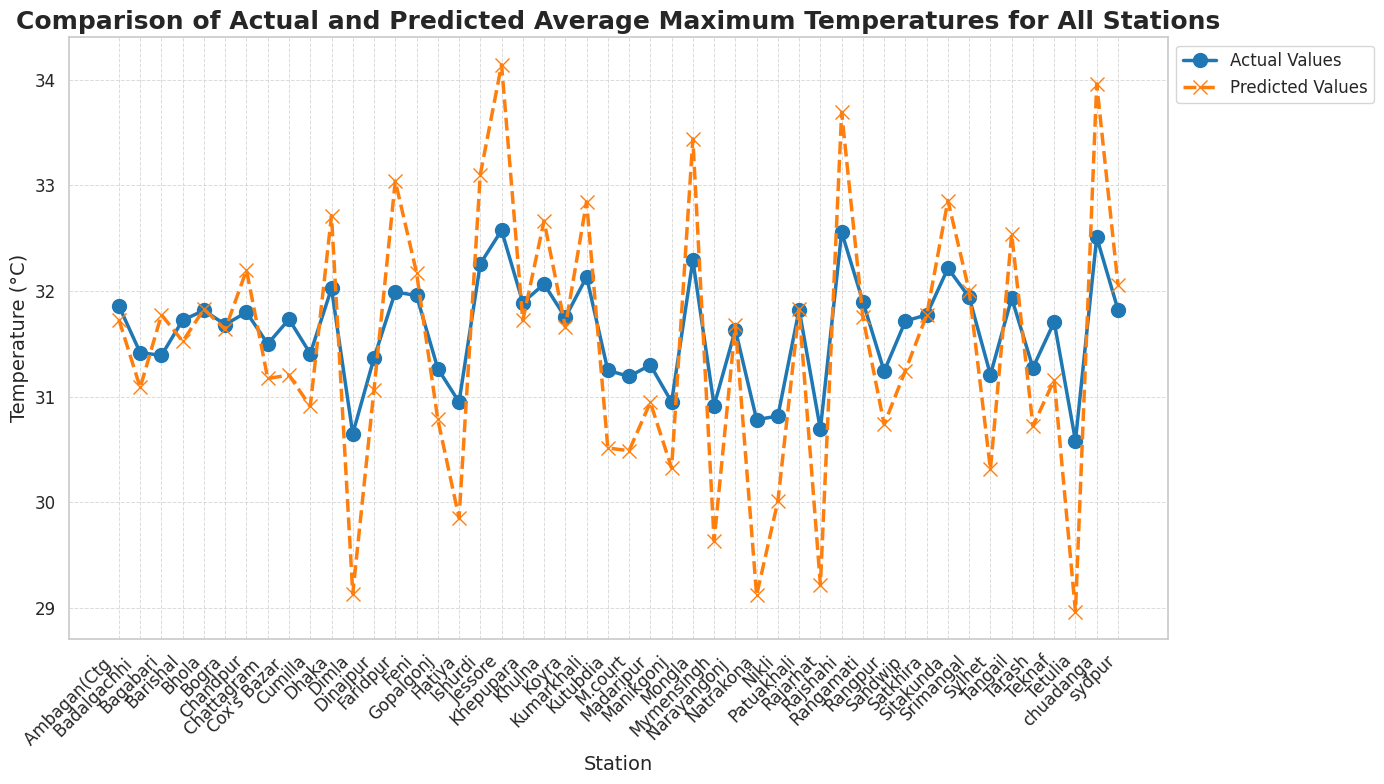

In [25]:
# Save the plot as a high-resolution PDF file for journal paper submission

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predicted results CSV file
predicted_data = pd.read_csv('/content/drive/MyDrive/climate/pre_maximum_23.csv')

# Set a clean style for the plot
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(14, 8))

# Sort the data by station if needed
predicted_data = predicted_data.sort_values('Station')

# Define colors and markers
actual_color = '#1f77b4'  # Blue for actual values
predicted_color = '#ff7f0e'  # Orange for predicted values
actual_marker = 'o'
predicted_marker = 'x'

# Plot the actual values
plt.plot(predicted_data['Station'], predicted_data['Actual Year'],
         label='Actual Values', marker=actual_marker, color=actual_color,
         linewidth=2.5, markersize=10, linestyle='-', zorder=2)

# Plot the predicted values
plt.plot(predicted_data['Station'], predicted_data['Predicted Value'],
         label='Predicted Values', marker=predicted_marker, color=predicted_color,
         linewidth=2.5, markersize=10, linestyle='--', zorder=2)

# Add gridlines (light, for clarity)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Titles and labels with enhanced fonts for readability
plt.title('Comparison of Actual and Predicted Average Maximum Temperatures for All Stations', fontsize=18, weight='bold')
plt.xlabel('Station', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

# Customize tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot to make the graph less crowded
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Add a tight layout to ensure no clipping of labels or titles
plt.tight_layout()

# Save the figure as a high-resolution PDF file suitable for journals
pdf_file_path = '/content/drive/MyDrive/climate/maximum_temperature_comparison_600dpi.pdf'
plt.savefig(pdf_file_path, format='pdf', dpi=600)

# Show the plot
plt.show()
